# Immorthon

In [11]:
!pip install transformers
!pip install datasets

In [16]:
import pandas as pd

dicoDir = "dictionnaries/"

# par ordre croissant de taille
dicoNames = ["dico-ef.csv", "dico-mit.csv", "dico-alpha.csv"]
dicoPath = dicoDir + dicoNames[2]

# cloner si on est sur colab
if 'google.colab' in str(get_ipython()):
    repoDir = "immorthon/"
    !rm -rf immorthon
    !git clone https://github.com/sully-vian/immorthon.git
    !cd immorthon && unzip model.zip
else:
    repoDir = ""

dicoPath = repoDir + dicoPath

# set pandas to print full strings
pd.set_option('display.max_colwidth', None)

df = pd.read_csv(dicoPath, encoding="utf-8", on_bad_lines="error", na_filter=False)
df["text"] = "Define: " + df["word"] + "\n" + df["definition"]

Cloning into 'immorthon'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 101 (delta 40), reused 64 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (101/101), 6.73 MiB | 20.50 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Archive:  model.zip
   creating: model/
  inflating: model/model.safetensors  
  inflating: model/generation_config.json  
  inflating: model/config.json       


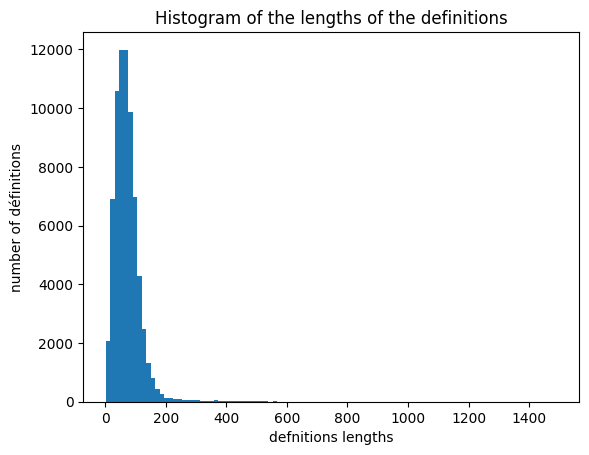

In [17]:
import matplotlib.pyplot as plt

definition_lengths = [len(definition) for definition in df["definition"]]
plt.hist(definition_lengths, bins=100)
plt.title('Histogram of the lengths of the definitions')
plt.xlabel('defnitions lengths')
plt.ylabel('number of définitions')
plt.show()

In [18]:
from datasets import Dataset

dataset = Dataset.from_pandas(df[["text"]])
# séparer aléatoirement la data en train et test
splitDataset = dataset.train_test_split(test_size=0.1)

In [30]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# par ordre croissant de taille
modelNames = [
    repoDir + "model/"
    "distilgpt2",
    "gpt2",
    "databricks/dolly-v2-3b" # trop lourd pour un T4 GPU
]
modelName = modelNames[0]
print(modelName)
tokenizer = AutoTokenizer.from_pretrained(modelName)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(modelName)

def tokenize(examples):
    encoding = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=100
    )
    encoding["labels"] = encoding["input_ids"].copy()
    return encoding

tokenizedDataset = splitDataset.map(tokenize, batched=True)

immorthon/model/distilgpt2


HFValidationError: Repo id must be in the form 'repo_name' or 'namespace/repo_name': 'immorthon/model/distilgpt2'. Use `repo_type` argument if needed.

In [10]:
from transformers import TrainingArguments, Trainer

trainingArgs = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="no",
    save_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=trainingArgs,
    train_dataset=tokenizedDataset["train"],
    eval_dataset=tokenizedDataset["test"],
    tokenizer=tokenizer,
)

trainer.train()

<ipython-input-10-eb22fd972da1>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,2.653200
20,0.909000
30,0.808600
40,0.677100
50,0.685000
60,0.692800
70,0.725700
80,0.647200
90,0.635800
100,0.706900


TrainOutput(global_step=7989, training_loss=0.5535951782218923, metrics={'train_runtime': 1314.1766, 'train_samples_per_second': 48.63, 'train_steps_per_second': 6.079, 'total_flos': 1630782620467200.0, 'train_loss': 0.5535951782218923, 'epoch': 1.0})

In [6]:
from transformers.pipelines import pipeline

generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

def generate(prompt, numDef):
    fullPrompt = f"Define: {prompt}\n"
    results = generator(fullPrompt, max_length=64, num_return_sequences=numDef, do_sample=True, temperature=0.7, truncation=True)
    return [result["generated_text"] for result in results]

for result in generate("", 3):
    print(result, end="\n\n")

NameError: name 'model' is not defined

# Pour sauver le modèle entrainé

In [26]:
!# AAA

# enregistrer le modèle
model.save_pretrained("model")
tokenizer.save_pretrained("model")
# zipper le modèle
!zip -r model.zip model

('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.json',
 'model/merges.txt',
 'model/added_tokens.json',
 'model/tokenizer.json')